<a href="https://colab.research.google.com/github/HamzaGbada/Backend/blob/master/VGG_EMbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/mlearning-ai/load-pre-trained-glove-embeddings-in-torch-nn-embedding-layer-in-under-2-minutes-f5af8f57416a

https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/

# TODO:
1. Dataloader should return list of data containing the image embedding and the image itself under pytorch tensor
1. perform class encoding when creating dataloader
1. the classifier at the first set it will be a full connected layer then a discuter


# VGG start

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2023-04-07 08:43:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-07 08:43:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-07 08:43:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
%%capture
!pip install tensorflow-addons
!pip install tf2onnx
!pip install "python-doctr[torch]"

In [ ]:
!pip install "python-doctr[torch]"

In [1]:
import numpy as np
from PIL import Image
import cv2
from copy import deepcopy
from typing import Tuple, TypeVar, Union, List
from pathlib import Path



def extract_crops(img: np.ndarray, boxes: np.ndarray, channels_last: bool = True) -> List[np.ndarray]:
    """Created cropped images from list of bounding boxes
    Args:
        img: input image
        boxes: bounding boxes of shape (N, 4) where N is the number of boxes, and the relative
            coordinates (xmin, ymin, xmax, ymax)
        channels_last: whether the channel dimensions is the last one instead of the last one
    Returns:
        list of cropped images
    """
    if boxes.shape[0] == 0:
        return []
    if boxes.shape[1] != 4:
        raise AssertionError("boxes are expected to be relative and in order (xmin, ymin, xmax, ymax)")

    # Project relative coordinates
    _boxes = boxes.copy()
    h, w = img.shape[:2] if channels_last else img.shape[-2:]
    if _boxes.dtype != int:
        _boxes[:, [0, 2]] *= w
        _boxes[:, [1, 3]] *= h
        _boxes = _boxes.round().astype(int)
        # Add last index
        _boxes[2:] += 1
    if channels_last:
        return deepcopy([img[box[1] : box[3], box[0] : box[2]] for box in _boxes])

    return deepcopy([img[:, box[1] : box[3], box[0] : box[2]] for box in _boxes])

def extract_rcrops(
    img: np.ndarray, polys: np.ndarray, dtype=np.float32, channels_last: bool = True
) -> List[np.ndarray]:
    """Created cropped images from list of rotated bounding boxes
    Args:
        img: input image
        polys: bounding boxes of shape (N, 4, 2)
        dtype: target data type of bounding boxes
        channels_last: whether the channel dimensions is the last one instead of the last one
    Returns:
        list of cropped images
    """
    if polys.shape[0] == 0:
        return []
    if polys.shape[1:] != (4, 2):
        raise AssertionError("polys are expected to be quadrilateral, of shape (N, 4, 2)")

    # Project relative coordinates
    _boxes = polys.copy()
    height, width = img.shape[:2] if channels_last else img.shape[-2:]
    if _boxes.dtype != int:
        _boxes[:, :, 0] *= width
        _boxes[:, :, 1] *= height

    src_pts = _boxes[:, :3].astype(np.float32)
    # Preserve size
    d1 = np.linalg.norm(src_pts[:, 0] - src_pts[:, 1], axis=-1)
    d2 = np.linalg.norm(src_pts[:, 1] - src_pts[:, 2], axis=-1)
    # (N, 3, 2)
    dst_pts = np.zeros((_boxes.shape[0], 3, 2), dtype=dtype)
    dst_pts[:, 1, 0] = dst_pts[:, 2, 0] = d1 - 1
    dst_pts[:, 2, 1] = d2 - 1
    # Use a warp transformation to extract the crop
    crops = [
        cv2.warpAffine(
            img if channels_last else img.transpose(1, 2, 0),
            # Transformation matrix
            cv2.getAffineTransform(src_pts[idx], dst_pts[idx]),
            (int(d1[idx]), int(d2[idx])),
        )
        for idx in range(_boxes.shape[0])
    ]
    return crops

def crop_bboxes_from_image(img_path: Union[str, Path], geoms: np.ndarray) -> List[np.ndarray]:
    """Crop a set of bounding boxes from an image
    Args:
        img_path: path to the image
        geoms: a array of polygons of shape (N, 4, 2) or of straight boxes of shape (N, 4)
    Returns:
        a list of cropped images
    """
    img: np.ndarray = np.array(Image.open(img_path).convert("RGB"))
    # Polygon
    if geoms.ndim == 3 and geoms.shape[1:] == (4, 2):
        return extract_rcrops(img, geoms.astype(dtype=int))
    if geoms.ndim == 2 and geoms.shape[1] == 4:
        return extract_crops(img, geoms.astype(dtype=int))
    raise ValueError("Invalid geometry format")

In [9]:
import json
import os
import shutil
from pathlib import Path
from typing import Any, Dict, List, Tuple
from torchtext.vocab import GloVe
from torchtext.data import get_tokenizer

import numpy as np

from doctr.datasets.datasets.pytorch import VisionDataset
from doctr.datasets.utils import convert_target_to_relative

__all__ = ['CORD']


# TODO: create a documentation for each dataloader especially the json of the output
class CORD(VisionDataset):
    """CORD dataset from `"CORD: A Consolidated Receipt Dataset forPost-OCR Parsing"
    <https://openreview.net/pdf?id=SJl3z659UH>`_.
    .. image:: https://github.com/mindee/doctr/releases/download/v0.5.0/cord-grid.png
        :align: center
    >>> from doctr.datasets import CORD
    >>> train_set = CORD(train=True, download=True)
    >>> img, target = train_set[0]
    Args:
        train: whether the subset should be the training one
        use_polygons: whether polygons should be considered as rotated bounding box (instead of straight ones)
        **kwargs: keyword arguments from `VisionDataset`.
    """
    TRAIN = ('https://github.com/mindee/doctr/releases/download/v0.1.1/cord_train.zip',
             '45f9dc77f126490f3e52d7cb4f70ef3c57e649ea86d19d862a2757c9c455d7f8')

    TEST = ('https://github.com/mindee/doctr/releases/download/v0.1.1/cord_test.zip',
            '8c895e3d6f7e1161c5b7245e3723ce15c04d84be89eaa6093949b75a66fb3c58')

    def __init__(
            self,
            train: bool = True,
            use_polygons: bool = False,
            **kwargs: Any,
    ) -> None:

        url, sha256 = self.TRAIN if train else self.TEST
        super().__init__(url, None, sha256, True, pre_transforms=convert_target_to_relative, **kwargs)

        # # List images
        tmp_root = os.path.join(self.root, 'image')
        self.train = train


        self.data: List[Tuple[str, Dict[str, Any]]] = []


        # model = torch.load('/content/cord_embedding.pt')
        # global_vectors = GloVe(name='6B', dim=100)
        # tokenizer = get_tokenizer("basic_english")


        np_dtype = np.float32
        text_unit_list = []
        for img_path in os.listdir(tmp_root):
            # File existence check
            if not os.path.exists(os.path.join(tmp_root, img_path)):
                raise FileNotFoundError(f"unable to locate {os.path.join(tmp_root, img_path)}")

            stem = Path(img_path).stem
            _targets = []

            with open(os.path.join(self.root, 'json', f"{stem}.json"), 'rb') as f:
                label = json.load(f)
                row_id_dic = {}
                for line in label["valid_line"]:
                    # text_unit = ""

                    for word in line["words"]:
                        if len(word["text"]) > 0:
                            # text_unit += word["text"] + " "
                            # row_id_dic[word['row_id']] += word["text"] + " "
                            if word['row_id'] in row_id_dic:
                                row_id_dic[word['row_id']] += word["text"].lower() + " "
                            else:
                                row_id_dic[word['row_id']] = word["text"].lower() + " "
                            x = word["quad"]["x1"], word["quad"]["x2"], word["quad"]["x3"], word["quad"]["x4"]
                            y = word["quad"]["y1"], word["quad"]["y2"], word["quad"]["y3"], word["quad"]["y4"]
                            if use_polygons:
                                # (x, y) coordinates of top left, top right, bottom right, bottom left corners
                                box = np.array([
                                    [x[0], y[0]],
                                    [x[1], y[1]],
                                    [x[2], y[2]],
                                    [x[3], y[3]],
                                ], dtype=np_dtype)
                            else:
                                # Reduce 8 coords to 4 -> xmin, ymin, xmax, ymax
                                box = [min(x), min(y), max(x), max(y)]
                            _targets.append(((word['text'].lower(), line["category"]), box))
                            # embedding = model.embeddings.weight[word_to_ix[word['text'].lower()]]
                            # try:
                            #   embedding = model.weight[word_to_ix[word['text'].lower()]]
                            # except KeyError:
                            #   embedding = embeddings = global_vectors.get_vecs_by_tokens([word['text'].lower()])
                            # _targets.append(((embedding, line["category"]), box))
                            # _targets.append(((word['text'].lower(), line["category"]), box))
                    # logger.debug(f"row id dict: {row_id_dic}")
                text_unit_list.append(row_id_dic)

            text_targets, box_targets = zip(*_targets)
            crops = crop_bboxes_from_image(
                    img_path=os.path.join(tmp_root, img_path), geoms=np.asarray(box_targets, dtype=int).clip(min=0)
                )
            self.data.append((
                img_path,
                dict(boxes=np.asarray(box_targets, dtype=int).clip(min=0), crops = crops ,labels=list(text_targets))
            ))
        self.text_units = text_unit_list
        self.root = tmp_root

    def extra_repr(self) -> str:
        return f"train={self.train}"

In [ ]:
dataset = CORD(train=True, download=True)



  0%|          | 0/1633132413 [00:00<?, ?it/s]

In [ ]:
dataset.data[0][1]["labels"][5]

In [ ]:
dataset.data[0][1]["labels"][15]

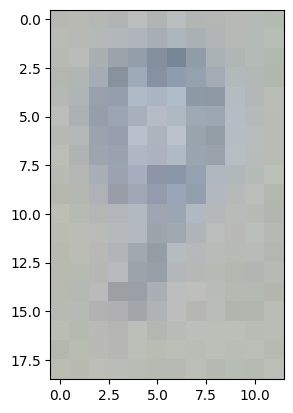

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dataset.data[0][1]["crops"][1])
plt.show()

In [ ]:
len(dataset.data)

800

In [ ]:
test_sentence = [dataset.data[i][1]["labels"][j][0] for i in range(len(dataset.data)) for j in range(len(dataset.data[i][1]["labels"]))]

In [ ]:
len(test_sentence)

19370

In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 100
# We will use Shakespeare Sonnet 2
test_sentence = [dataset.data[i][1]["labels"][j][0] for i in range(len(dataset.data)) for j in range(len(dataset.data[i][1]["labels"]))]
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(50):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print(f'epochs: {epoch}, loss: {total_loss}')
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["35.000"]])
torch.save(model.embeddings, "/content/cord_embedding.pt")

[(['9', 'kupon'], '8,182'), (['8,182', '9'], 'kupon'), (['kupon', '8,182'], '1')]
epochs: 0, loss: 147525.7649732679
epochs: 1, loss: 134020.00229025632
epochs: 2, loss: 126232.6497439444
epochs: 3, loss: 120423.40088605136
epochs: 4, loss: 115930.25840944797
epochs: 5, loss: 112193.267016422
epochs: 6, loss: 108833.57612579316
epochs: 7, loss: 105661.17124858405
epochs: 8, loss: 102583.56508761551
epochs: 9, loss: 99546.81386568397
epochs: 10, loss: 96520.20740602585
epochs: 11, loss: 93485.10138954222
epochs: 12, loss: 90437.86383028887
epochs: 13, loss: 87376.11923415423
epochs: 14, loss: 84306.24976813851
epochs: 15, loss: 81228.81072086724
epochs: 16, loss: 78148.28703508287
epochs: 17, loss: 75077.05377115723
epochs: 18, loss: 72024.09192587767
epochs: 19, loss: 69001.34178799579
epochs: 20, loss: 66016.0419233802
epochs: 21, loss: 63080.24110282639
epochs: 22, loss: 60201.99913725092
epochs: 23, loss: 57387.366835213914
epochs: 24, loss: 54644.503529309644
epochs: 25, loss: 5197

In [ ]:
model.embeddings.weight

Parameter containing:
tensor([[-1.0411,  1.0701,  0.8174,  ...,  0.2639,  0.3720, -0.3693],
        [ 0.3026, -0.6482, -1.1100,  ...,  1.0809,  0.1345,  0.2780],
        [ 1.3898,  0.8371,  0.2167,  ...,  0.8164, -0.4949,  0.8771],
        ...,
        [-0.3865, -1.0182,  2.5876,  ..., -0.2733, -0.2047, -0.0950],
        [-0.2679, -1.3657, -0.7658,  ..., -0.4955, -1.7007, -0.7512],
        [-1.8812, -1.5214,  0.6301,  ...,  0.0595, -0.2884, -1.4445]],
       requires_grad=True)

In [10]:
import json
import torch
import os
import shutil
from pathlib import Path
from typing import Any, Dict, List, Tuple
from torchtext.vocab import GloVe
from torchtext.data import get_tokenizer

import numpy as np

from doctr.datasets.datasets.pytorch import VisionDataset
from doctr.datasets.utils import convert_target_to_relative

__all__ = ['CORDEmbed']


# TODO: create a documentation for each dataloader especially the json of the output
class CORDEmbed(VisionDataset):
    """CORD dataset from `"CORD: A Consolidated Receipt Dataset forPost-OCR Parsing"
    <https://openreview.net/pdf?id=SJl3z659UH>`_.
    .. image:: https://github.com/mindee/doctr/releases/download/v0.5.0/cord-grid.png
        :align: center
    >>> from doctr.datasets import CORD
    >>> train_set = CORD(train=True, download=True)
    >>> img, target = train_set[0]
    Args:
        train: whether the subset should be the training one
        use_polygons: whether polygons should be considered as rotated bounding box (instead of straight ones)
        **kwargs: keyword arguments from `VisionDataset`.
    """
    TRAIN = ('https://github.com/mindee/doctr/releases/download/v0.1.1/cord_train.zip',
             '45f9dc77f126490f3e52d7cb4f70ef3c57e649ea86d19d862a2757c9c455d7f8')

    TEST = ('https://github.com/mindee/doctr/releases/download/v0.1.1/cord_test.zip',
            '8c895e3d6f7e1161c5b7245e3723ce15c04d84be89eaa6093949b75a66fb3c58')

    def __init__(
            self,
            train: bool = True,
            use_polygons: bool = False,
            **kwargs: Any,
    ) -> None:

        url, sha256 = self.TRAIN if train else self.TEST
        super().__init__(url, None, sha256, True, pre_transforms=convert_target_to_relative, **kwargs)

        # # List images
        tmp_root = os.path.join(self.root, 'image')
        self.train = train


        self.data: List[Tuple[str, Dict[str, Any]]] = []
        dataset = CORD(train=True, download=True)
        CONTEXT_SIZE = 2
        EMBEDDING_DIM = 100
        # We will use Shakespeare Sonnet 2
        test_sentence = [dataset.data[i][1]["labels"][j][0] for i in range(len(dataset.data)) for j in range(len(dataset.data[i][1]["labels"]))]
        # we should tokenize the input, but we will ignore that for now
        # build a list of tuples.
        # Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
        ngrams = [
            (
                [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
                test_sentence[i]
            )
            for i in range(CONTEXT_SIZE, len(test_sentence))
        ]
        # Print the first 3, just so you can see what they look like.
        # print(ngrams[:3])

        vocab = set(test_sentence)
        word_to_ix = {word: i for i, word in enumerate(vocab)}

        model = torch.load('/content/cord_embedding.pt')
        global_vectors = GloVe(name='6B', dim=100)
        tokenizer = get_tokenizer("basic_english")


        np_dtype = np.float32
        text_unit_list = []
        for img_path in os.listdir(tmp_root):
            # File existence check
            if not os.path.exists(os.path.join(tmp_root, img_path)):
                raise FileNotFoundError(f"unable to locate {os.path.join(tmp_root, img_path)}")

            stem = Path(img_path).stem
            _targets = []

            with open(os.path.join(self.root, 'json', f"{stem}.json"), 'rb') as f:
                label = json.load(f)
                row_id_dic = {}
                for line in label["valid_line"]:
                    # text_unit = ""

                    for word in line["words"]:
                        if len(word["text"]) > 0:
                            # text_unit += word["text"] + " "
                            # row_id_dic[word['row_id']] += word["text"] + " "
                            if word['row_id'] in row_id_dic:
                                row_id_dic[word['row_id']] += word["text"].lower() + " "
                            else:
                                row_id_dic[word['row_id']] = word["text"].lower() + " "
                            x = word["quad"]["x1"], word["quad"]["x2"], word["quad"]["x3"], word["quad"]["x4"]
                            y = word["quad"]["y1"], word["quad"]["y2"], word["quad"]["y3"], word["quad"]["y4"]
                            if use_polygons:
                                # (x, y) coordinates of top left, top right, bottom right, bottom left corners
                                box = np.array([
                                    [x[0], y[0]],
                                    [x[1], y[1]],
                                    [x[2], y[2]],
                                    [x[3], y[3]],
                                ], dtype=np_dtype)
                            else:
                                # Reduce 8 coords to 4 -> xmin, ymin, xmax, ymax
                                box = [min(x), min(y), max(x), max(y)]
                            # _targets.append(((word['text'].lower(), line["category"]), box))
                            # ## embedding = model.embeddings.weight[word_to_ix[word['text'].lower()]]
                            try:
                              embedding = model.weight[word_to_ix[word['text'].lower()]]
                            except KeyError:
                              embedding = embeddings = global_vectors.get_vecs_by_tokens([word['text'].lower()])
                            _targets.append(((embedding, line["category"]), box))
                            # _targets.append(((word['text'].lower(), line["category"]), box))
                    # logger.debug(f"row id dict: {row_id_dic}")
                text_unit_list.append(row_id_dic)

            text_targets, box_targets = zip(*_targets)
            crops = crop_bboxes_from_image(
                    img_path=os.path.join(tmp_root, img_path), geoms=np.asarray(box_targets, dtype=int).clip(min=0)
                )
            self.data.append((
                img_path,
                dict(boxes=np.asarray(box_targets, dtype=int).clip(min=0), crops = crops ,labels=list(text_targets))
            ))
        self.text_units = text_unit_list
        self.root = tmp_root

    def extra_repr(self) -> str:
        return f"train={self.train}"

In [11]:
dataset = CORDEmbed(train=True, download=True)

[(['52.636', 'dpp'], 'isi'), (['isi', '52.636'], 'campur'), (['campur', 'isi'], '1')]


In [12]:
len(dataset.data)

800

In [16]:
dataset.data[0][1]["labels"][5][1]

'menu.unitprice'

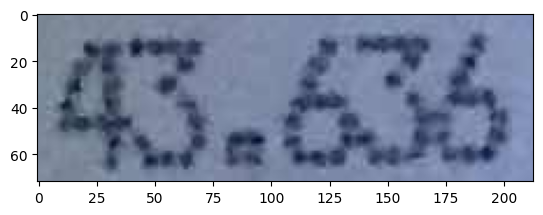

In [18]:

import matplotlib.pyplot as plt
plt.imshow(dataset.data[0][1]["crops"][5])
plt.show()

In [92]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


class CORDTORCH(Dataset):
    def __init__(self, train=True):
        dataset = CORDEmbed(train=train, download=True)
        self.img_labels = [dataset.data[i][1]["labels"][j][1] for i in range(len(dataset.data)) for j in range(len(dataset.data[i][1]["labels"]))]
        self.images = [dataset.data[i][1]["crops"][j] for i in range(len(dataset.data)) for j in range(len(dataset.data[i][1]["labels"]))]
        self.word_tensors = [dataset.data[i][1]["labels"][j][0] for i in range(len(dataset.data)) for j in range(len(dataset.data[i][1]["labels"]))]
        # self.img_dir = img_dir
        # self.transform = transform
        # self.target_transform = target_transform

    def __len__(self):
        print(len(self.img_labels), len(self.images), len(self.word_tensors))
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = self.images[idx]
        transform = transforms.Compose([
            ToTensor()
        ])
        image = transform(image)
        print("image.shape")
        print(image.shape)
        word_embed = self.word_tensors[idx]
        label = self.img_labels[idx]
        print("THE LEEEEEEEEEEEEEEEEEEEEEEBELLLLLLLLLLLLL")
        print(label)
        return image, word_embed,label

In [93]:
cordTorch_train = CORDTORCH()
cordTorch_test = CORDTORCH(train=False)

[(['52.636', 'dpp'], 'isi'), (['isi', '52.636'], 'campur'), (['campur', 'isi'], '1')]
[(['52.636', 'dpp'], 'isi'), (['isi', '52.636'], 'campur'), (['campur', 'isi'], '1')]


In [41]:
len(cordTorch_test)

2186 2186 2186


2186

In [42]:
import torch
import torchvision
import torchvision.transforms as transforms

In [85]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(cordTorch_train, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(cordTorch_test, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('menu.sub_cnt',
                       'sub_total.othersvc_price',
                       'total.total_price',
                       'menu.etc',
                       'sub_total.discount_price',
                       'menu.unitprice',
                       'menu.discountprice',
                       'void_menu.price',
                       'menu.nm',
                       'total.menutype_cnt',
                       'sub_total.subtotal_price',
                       'menu.sub_nm',
                       'void_menu.nm',
                       'menu.sub_unitprice',
                       'menu.sub_etc',
                       'menu.cnt',
                       'menu.vatyn',
                       'total.total_etc',
                       'total.menuqty_cnt',
                       'total.cashprice',
                       'menu.num',
                       'total.changeprice',
                       'sub_total.tax_price',
                       'sub_total.etc',
                       'menu.price',
                       'total.creditcardprice',
                       'total.emoneyprice',
                       'sub_total.service_price',
                       'menu.itemsubtotal',
                       'menu.sub_price')

19370 19370 19370
19370 19370 19370


In [96]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, is_tensor, from_numpy


class Net(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 2, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Sequential(
            nn.LazyLinear(100),
            # nn.ReLU(True),
            # nn.Linear(128, embed_size)
        )

    def forward(self, images, word_embed):
        if not is_tensor(images):
            images = from_numpy(images)
        print("images.shape")
        print(images.shape)
        print("word_embed.shape")
        print(word_embed.shape)
        print("x.type")
        print(type(images))
        print("word_embed.type")
        print(type(word_embed))
        images = self.cnn(images)
        images = self.flatten(images)
        images = self.linear(images)
        print("images.shape1")
        print(images.shape)
        print("word_embed.shape1")
        print(word_embed.shape)
        print("x.type1")
        print(type(images))
        print("word_embed.type1")
        print(type(word_embed))
        # x = self.fc3(x)
        return images


net = Net(100)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [97]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [99]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, word_embed, labels = data
        print("booooooooooooooooooooooooooooooooooooob")
        print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs, word_embed)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

19370 19370 19370
19370 19370 19370
image.shape
torch.Size([3, 16, 10])
booooooooooooooooooooooooooooooooooooob
('menu.price',)
images.shape
torch.Size([1, 3, 16, 10])
word_embed.shape
torch.Size([1, 100])
x.type
<class 'torch.Tensor'>
word_embed.type
<class 'torch.Tensor'>


RuntimeError: ignored

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)